In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from tqdm import tqdm # This allows you to wrap any iterable in python and it then creates a progress bar for you within jupyter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

!pip install pydub
# python speech features is an audio library
!pip install python_speech_features
from python_speech_features import mfcc, logfbank

# This is the common audio library
import librosa

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=aa2d951bffb74b848b2e06d4ee1e607029ac99824793e1e52f6e5e3e25431365
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:


# copy the data to /kaggle/working/
!cp -r '/content/drive/MyDrive/Projects/RNN/ProjectAudio-20230820T141630Z-001/ProjectAudio'




cp: missing destination file operand after '/content/drive/MyDrive/Projects/RNN/ProjectAudio-20230820T141630Z-001/ProjectAudio'
Try 'cp --help' for more information.


In [ ]:
base_path = '/content/drive/MyDrive/Projects/RNN/ProjectAudio-20230820T141630Z-001/ProjectAudio/audiomentation'
file_ls = os.listdir(base_path)

FileNotFoundError: ignored

In [ ]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=18)
    i = 0
    for x in range(1):
        for y in range(3):
            axes[y].set_title(list(signals.keys())[i])
            axes[y].plot(list(signals.values())[i])
            axes[y].get_xaxis().set_visible(False)
            axes[y].get_yaxis().set_visible(False)
            i += 1


def plot_fft(fft):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=18)
    i = 0
    for x in range(1):
        for y in range(3):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[y].set_title(list(fft.keys())[i])
            axes[y].plot(freq, Y)
            axes[y].get_xaxis().set_visible(False)
            axes[y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=18)
    i = 0
    for x in range(1):
        for y in range(3):
            axes[y].set_title(list(fbank.keys())[i])
            axes[y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[y].get_xaxis().set_visible(False)
            axes[y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=18)
    i = 0
    for x in range(1):
        for y in range(3):
            axes[y].set_title(list(mfccs.keys())[i])
            axes[y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[y].get_xaxis().set_visible(False)
            axes[y].get_yaxis().set_visible(False)
            i += 1


# FFT has two parts (magnitude and frequency)
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate) # This goes to the x-axis with the spaces between the samples (d)
    Y = abs(np.fft.rfft(y)/n) # Generate the magnitude - This is the y-axis. Normalize the length of the signal by dividing by n
    return (Y, freq)

# Function to detect the estimation of the magnitude i.e. the Amplitude of the signal i.e. if the amplitude is too low
# then it can be stripped off since the audio has died out
# Basically to do Noise Forward Detection of the signal
def envelop(y,rate,threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),min_periods=1,center=True).mean()

    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)

    return mask

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Projects/RNN/dataa.csv')

df=df.shift(-1)
df.sample(10)


,file_name,class_name,length
8388,augmented_noise_0_immature.augmented_pitch_0_i...,immature,3.000
13763,augmented_pitch_4_mature.augmented_pitch_0_mat...,mature,3.000
2299,augmented_stretch_3_overmature.augmented_pitch...,overmature,2.792
2869,augmented_vibrato_2_overmature.overmature-11.w...,overmature,3.000
9943,augmented_vibrato_3_overmature.augmented_stret...,overmature,3.120
1351,augmented_filter_2_immature.augmented_pitch_0_...,immature,2.995
720,augmented_time_shift_3_immature.immature-8.wav...,immature,3.000
4530,augmented_filter_2_overmature.augmented_stretc...,overmature,3.042
5633,augmented_time_shift_3_mature.augmented_shift_...,mature,3.000
4016,augmented_stretch_0_overmature.augmented_pitch...,overmature,3.199


In [ ]:
class_counts = df['class_name'].value_counts()
print(class_counts)

overmature    5850
mature        4050
immature      4049
class_name       5
Name: class_name, dtype: int64


In [ ]:
import os
import csv
from pydub import AudioSegment

# Set the path to the folder containing the audio files
audio_folder = '/content/drive/MyDrive/Projects/RNN/ProjectAudio-20230820T141630Z-001/ProjectAudio/audiomentation'

# Set the path to the CSV file
csv_file = '/content/drive/MyDrive/Projects/RNN/dataa.csv'

# Open the CSV file for reading and writing
with open(csv_file, 'r') as f:
    reader = csv.DictReader(f)
    header.append('length')

# Loop through the rows of the CSV file
for row in rows:
    if row['file_name'] == 'file_name':  # <====== Something is missing here.
      continue
      # Get the filename of the audio file from the 'file_name' column
    audio_file = os.path.join(audio_folder+'/'+row['class_name'], row['file_name'])

      # Load the audio signal using pydub
    audio = AudioSegment.from_file(audio_file)

      # Compute the length of the audio signal in seconds
    length = len(audio) / 1000

      # Add the length to the row
    row['length'] = length

# Write the updated rows to the CSV file
with open(csv_file, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=header)
    writer.writeheader()
    writer.writerows(rows)


NameError: ignored

In [ ]:


df = pd.read_csv('/content/drive/MyDrive/Projects/RNN/dataa.csv')

df.sample(10)



,file_name,class_name,length
2444,augmented_time_shift_1_overmature.overmature-1...,overmature,3.000
6252,augmented_filter_1_mature.augmented_shift_0_ma...,mature,2.995
6424,augmented_noise_0_mature.augmented_shift_0_mat...,mature,3.000
9633,augmented_time_shift_3_overmature.overmature-1...,overmature,3.000
6720,augmented_pitch_2_mature.augmented_stretch_0_m...,mature,3.156
8268,augmented_filter_2_immature.augmented_shift_0_...,immature,2.995
11317,augmented_compression_0_overmature.augmented_s...,overmature,3.000
7088,augmented_sep_3_immature.augmented_pitch_0_imm...,immature,3.000
3893,augmented_shift_2_overmature.overmature-1.wav....,overmature,3.000
12970,augmented_compression_0_mature.mature-7.wav.3u...,mature,3.000


In [ ]:


class_counts = df['class_name'].value_counts()
print(class_counts)



overmature    5850
immature      4050
mature        4050
class_name       5
Name: class_name, dtype: int64


In [ ]:


# Create an index column
df.set_index('file_name',inplace=True)



In [ ]:


# Add a new column and label it length
for f in df.index:
    rate,signal = wavfile.read(audio_folder+f)
    df.at[f,'length'] = signal.shape[0]/rate #This will give the length of the signal in seconds



FileNotFoundError: ignored

In [ ]:
# View the dataframe with the new column
df.sample(10)


,class_name,length
file_name,,
augmented_filter_0_overmature.augmented_pitch_0_overmature-6.wav.3ugrsgq9.ingestion-7f8fb74cdc-tfzn2.wav,overmature,2.995
augmented_sep_0_mature.mature-3.wav.3ugrv22r.ingestion-7f8fb74cdc-t9dr8.wav,mature,3.000
augmented_sep_3_overmature.overmature-18.wav.3ugs00mh.ingestion-7f8fb74cdc-fthmx.wav,overmature,3.000
augmented_vibrato_4_mature.mature-13.wav.3ugrv4ek.ingestion-7f8fb74cdc-tfzn2.wav,mature,3.000
augmented_noise_0_mature.augmented_stretch_0_mature-2.wav.3ugrqlsl.ingestion-7f8fb74cdc-t9dr8.wav,mature,3.156
augmented_sep_3_immature.augmented_shift_0_immature-9.wav.3ugropdg.ingestion-7f8fb74cdc-t9dr8.wav,immature,3.000
augmented_pitch_4_mature.augmented_shift_0_mature-10.wav.3ugrqkms.ingestion-7f8fb74cdc-tfzn2.wav,mature,3.000
augmented_pitch_3_overmature.augmented_pitch_0_overmature-17.wav.3ugrsgtf.ingestion-7f8fb74cdc-tfzn2.wav,overmature,3.000
augmented_time_shift_3_mature.mature-4.wav.3ugrv3fk.ingestion-7f8fb74cdc-fthmx.wav,mature,3.000


In [ ]:


# Checkout the number of voice files for the human
df[df['class_name'] == 'overmature'].count()



class_name    5850
length        5850
dtype: int64

In [ ]:


# Generate the classes
classes = list(np.unique(df.class_name))



In [ ]:
# Generate a class distributions
# The audio files have different lengths of audio and we may have issues with class bounds
class_dist1 = df.groupby(['class_name'])['length'].mean() # Just to show the mean of the length

fig, ax = plt.subplots()
ax.set_title("Distribution by Audio Length", y=1.08)
ax.pie(class_dist1,labels=class_dist1.index,autopct='%1.1f%%',shadow=False,startangle=90)
ax.axis('equal')
plt.show()


ValueError: ignored

ValueError: ignored

<Figure size 640x480 with 1 Axes>

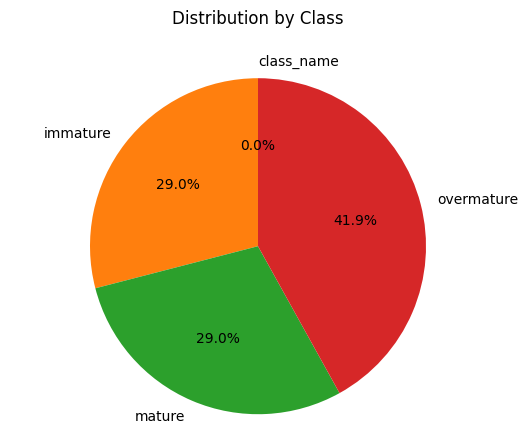

In [ ]:


class_dist2 = df.groupby(['class_name'])['length'].agg(['count'])

plt.pie(class_dist2['count'].values.ravel(), labels=class_dist2.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution by Class', y=1.08)
plt.show()
df = df.reset_index()



In [ ]:


# Create the dictionaries to store the data
signals = {}
fft = {}
fbank = {}
mfccs = {}

# Create dictionaries to hold the cleaned data
cleaned_signals = {}
cleaned_fft = {}
cleaned_fbank = {}
cleaned_mfccs = {}



In [ ]:


# Generate Time Series

# For each of the classes, get one audio file and plot
for c in ['immature','mature','overmature']:
    wav_file = df[df.class_name == c].sample(n=1).iloc[0]['file_name']
    signal, rate = librosa.load(audio_folder+'/'+c+'/'+wav_file,sr=44100) # 44100 is the sampling rate

    signals[c] = signal

    fft[c] = calc_fft(signal,rate) # Calculate the Fast Fourier Transform

    # Filter bank in log. 26 is a standard value for the filter.  nfft is the window length
    bank = logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
    fbank[c] = bank

    # Generate the Mel-Frequency Ceptrum Coefficient
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel



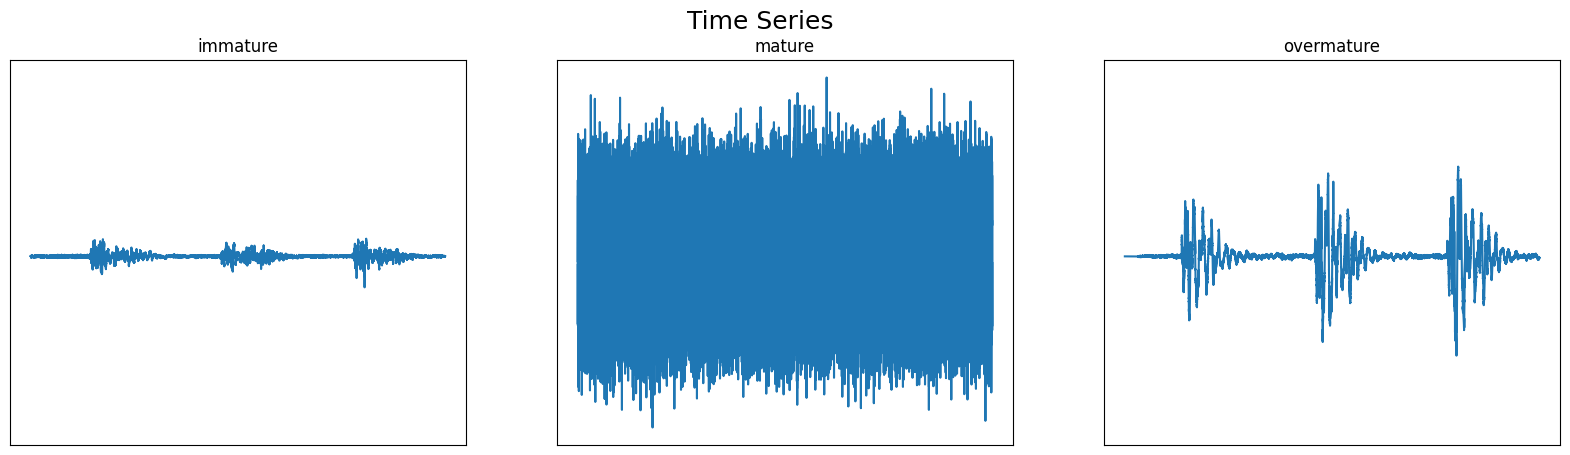

In [ ]:
# Some have alot of noise begining and end of the signal and needs to be removed since there is no signal i.e. Noise threshold detection
plot_signals(signals)
plt.show()

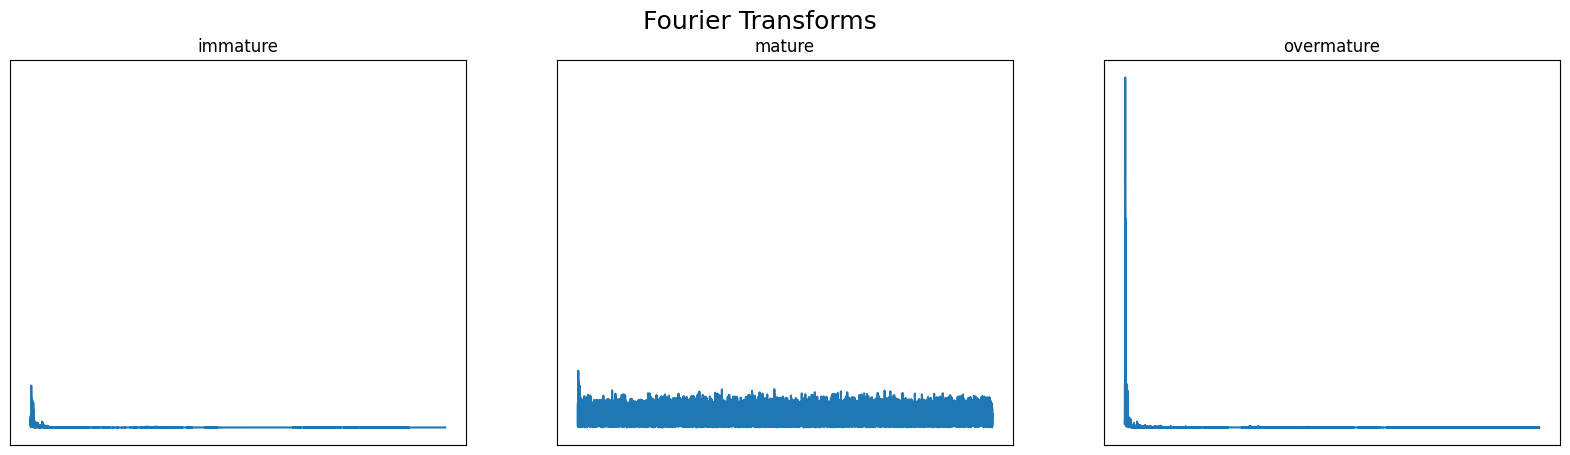

In [ ]:


plot_fft(fft)
plt.show()



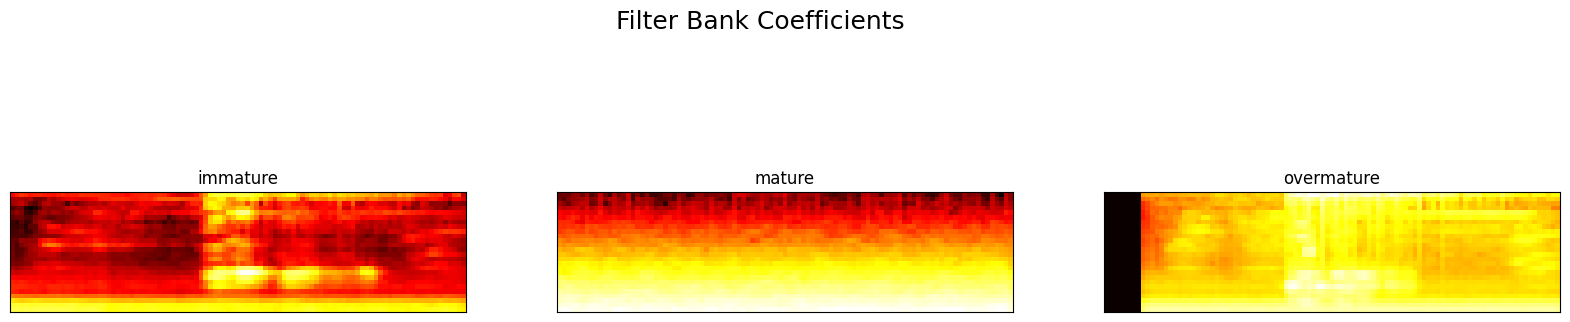

In [ ]:


plot_fbank(fbank)
plt.show()



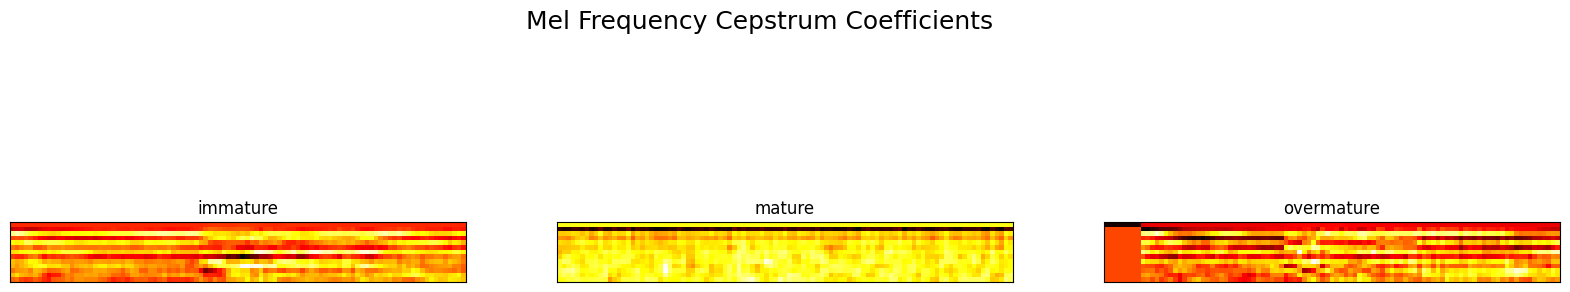

In [ ]:


# When you do the Discrete Cosine Transform (DCT) on the filter banks, you get a more refined representation ready to be used
# for machine learning
plot_mfccs(mfccs)
plt.show()



In [ ]:


# Generate Time Series
for cleaned_c in classes:

    cleaned_wav_file = df[df.class_name == cleaned_c].sample(n=1).iloc[0,0]
    if cleaned_wav_file=='file_name':
      continue
    signal, rate = librosa.load(base_path+"/"+cleaned_c+"/"+cleaned_wav_file,sr=44100) # 44100 is the sampling rate
    mask = envelop(signal,rate,0.0005) # Call the envelop method
    signal = signal[mask]
    cleaned_signals[cleaned_c] = signal
    cleaned_fft[cleaned_c] = calc_fft(signal,rate)
    cleaned_bank = logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
    cleaned_fbank[cleaned_c] = cleaned_bank
    cleaned_mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    cleaned_mfccs[cleaned_c] = cleaned_mel



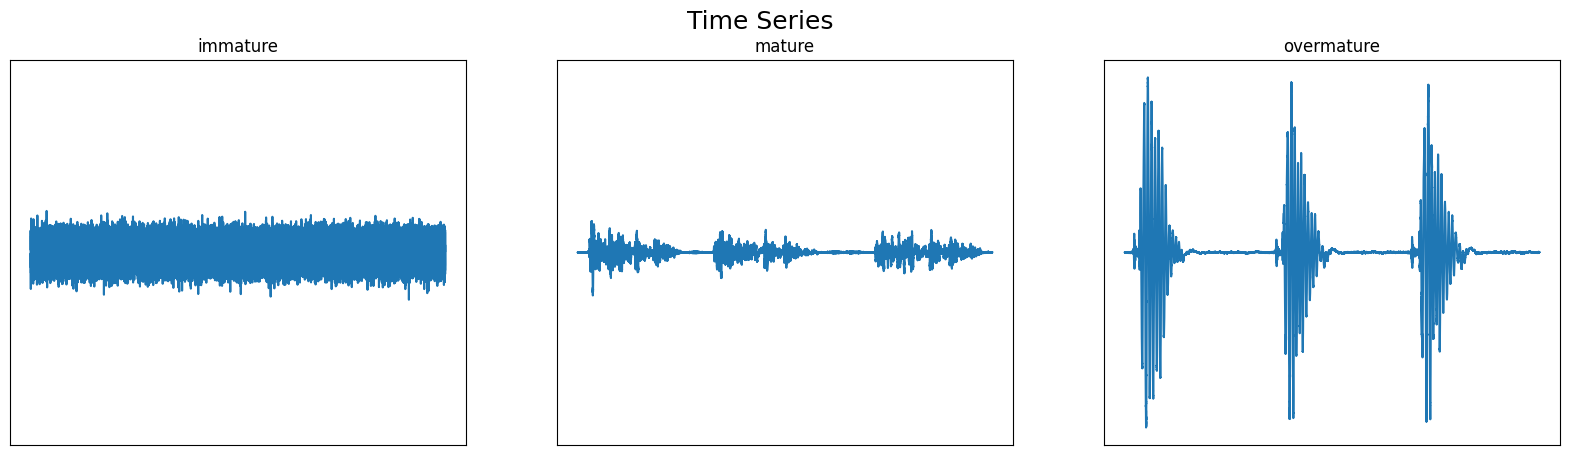

In [ ]:
# View the graphs again without the dead signals

plot_signals(cleaned_signals)
plt.show()


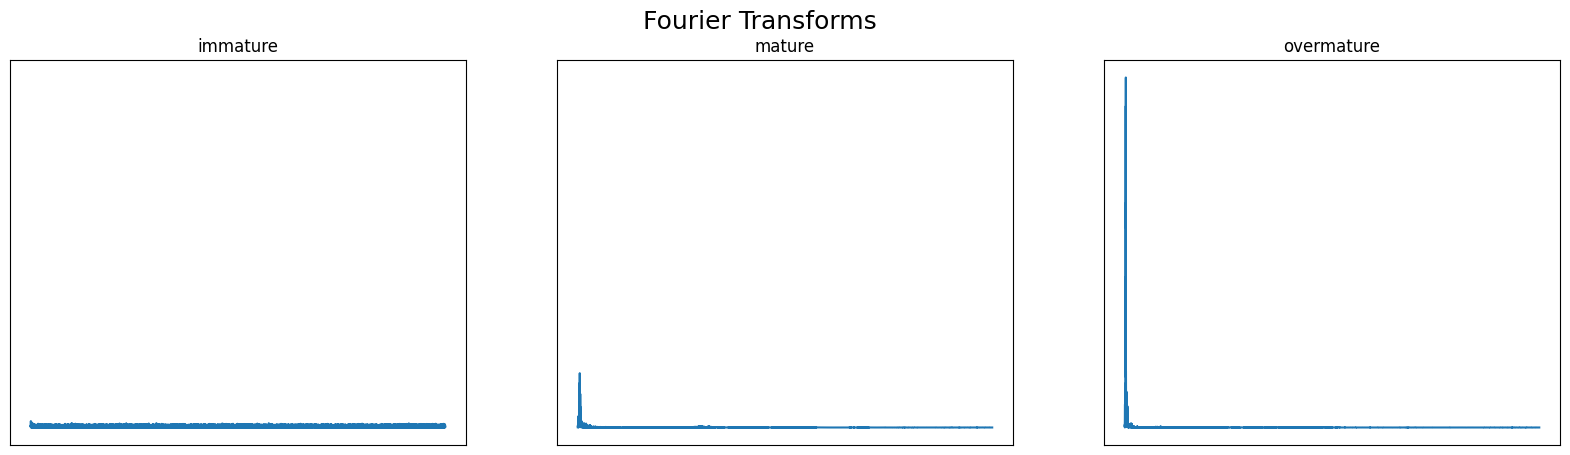

In [ ]:
# Plot the FFT of the cleaned signals

plot_fft(cleaned_fft)
plt.show()